Exploring Completion Percentages
=============================

This is an initial notebook for doing exploratory data analysis on the Predict Podcast Listening Time from Kaggle. This specific notebook looks at how different features (genre, sentiment, host popularity) impact the overall percentage of completion for any given episode.

# Import Libraries / Set Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Training Data

In [2]:
DATA_DIR = "../data/kaggle/"

df_train = pd.read_csv( DATA_DIR + "train.csv" )
df_test = pd.read_csv( DATA_DIR + "test.csv" )

# Duplicates?

In [3]:
df_ = pd.concat([df_train, df_test])
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 249999
Data columns (total 12 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   id                           1000000 non-null  int64  
 1   Podcast_Name                 1000000 non-null  object 
 2   Episode_Title                1000000 non-null  object 
 3   Episode_Length_minutes       884171 non-null   float64
 4   Genre                        1000000 non-null  object 
 5   Host_Popularity_percentage   1000000 non-null  float64
 6   Publication_Day              1000000 non-null  object 
 7   Publication_Time             1000000 non-null  object 
 8   Guest_Popularity_percentage  805138 non-null   float64
 9   Number_of_Ads                999999 non-null   float64
 10  Episode_Sentiment            1000000 non-null  object 
 11  Listening_Time_minutes       750000 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage:

In [4]:
columns = [ "Podcast_Name",
            "Episode_Title",
            "Episode_Length_minutes",
            "Publication_Day",
            "Publication_Time" ]

df_["Duplicated"] = df_[ columns ].duplicated()

# Filter and show duplicate rows
#duplicate_rows = df_["Duplicated"]
#print(f"Number of duplicates: {len(duplicate_rows)}")

How many versions of "Digital Digest, Episode 49" exist with the same runtime?

In [5]:
df_sub = df_[ (df_["Podcast_Name"] == "Digital Digest") &  
              (df_["Episode_Title"] == "Episode 49") &
              (df_["Publication_Day"] == "Thursday") &
              (df_["Publication_Time"] == "Morning") &
              (df_["Duplicated"] == False) ].copy()

df_sub[[ "Podcast_Name", "Episode_Title", "Episode_Length_minutes", "Host_Popularity_percentage", "Guest_Popularity_percentage", 
         "Number_of_Ads", "Episode_Sentiment", "Listening_Time_minutes"]].head(5).style.hide(axis="index")

Podcast_Name,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
Digital Digest,Episode 49,nan,76.490000,42.720000,2.000000,Positive,16.690000
Digital Digest,Episode 49,50.340000,27.770000,84.440000,1.000000,Neutral,32.060000
Digital Digest,Episode 49,118.190000,47.310000,69.780000,1.000000,Negative,112.960000
Digital Digest,Episode 49,96.380000,43.390000,85.860000,3.000000,Positive,77.762110
Digital Digest,Episode 49,78.470000,27.620000,38.060000,0.000000,Positive,62.041640


It appears from the above data that the episode title "Episode 49" applies to multiple episodes of the same podcast,
as each id above has a different episode length, different publication day and different publication time. For the
purposes of this notebook, and future models, we're going to consider episode name to be irrelevant, and each
individual row / id is unique.

# Episode Completion Percentage

Load the test and training data into one dataframe for feature engineering. 

For the purposes of this initial analysis, drop the row that have N/A values.

In [6]:
df_.dropna(inplace=True)
df_.shape

(539048, 13)

In [7]:
df_["Episode_Completion"] = df_["Listening_Time_minutes"] / df_["Episode_Length_minutes"]

How many listening events have listening time longer than episode length?

It turns out that about 2000 listening entries actually somehow listen to MORE than the length of the 
episode. Inquiring minds as: "how is that possible"???

In [8]:
df_[ df_["Episode_Completion"] > 1 ].shape

(2081, 14)

For the purposes of initial exploration, let's only focus on the listening sessions where 
the listening time did NOT exceed the episode length.

In [9]:
df_ = df_[ df_["Episode_Completion"] <= 1 ]
df_.shape

(536967, 14)

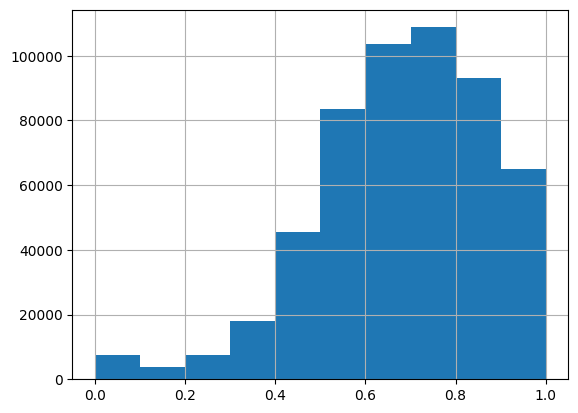

In [10]:
df_["Episode_Completion"].hist()
plt.show()

# Most Completed Podcasts

Create a dataframe showing the average completion percentage for any given podcast.

In [11]:
df_average_values = df_.groupby('Podcast_Name')['Episode_Completion'].mean()
df_average_values.sort_values(inplace=True, ascending=False)

First of all, how many different podcasts are in the dataset?

In [12]:
print(len(df_average_values))

48


In [13]:
df_average_values.head(3)

Podcast_Name
True Crime Stories    0.699222
Tech Talks            0.699006
Detective Diaries     0.693703
Name: Episode_Completion, dtype: float64

In [14]:
df_average_values.tail(3)

Podcast_Name
Global News       0.669204
World Watch       0.668207
Sports Central    0.657844
Name: Episode_Completion, dtype: float64

Because the average completion time for different podcasts is so close together, that would indicate that
the data is generated synthetically. This will change how the model is further developed within the dataset.

# Host Popularity

Does host popularity shift for a particular podcast series? Let's look at "True Crime Stories".

In [15]:
df_pod = df_[ df_[ "Podcast_Name" ] == "True Crime Stories" ]
df_pod.shape

(11956, 14)

## All Episodes

In [16]:
df_pod["Host_Popularity_percentage"].describe()

count    11956.000000
mean        58.905034
std         22.236322
min         20.010000
25%         39.140000
50%         59.260000
75%         77.752500
max        112.250000
Name: Host_Popularity_percentage, dtype: float64

## One Episode

In [17]:
df_episode = df_pod[ df_pod["Episode_Title"] == "Episode 16" ]
print(f"Episode count: {df_episode["Host_Popularity_percentage"].count()}")
print(f"Host popularity mean: {df_episode["Host_Popularity_percentage"].mean()}")
print(f"Host popularity std: {df_episode["Host_Popularity_percentage"].std()}")

Episode count: 98
Host popularity mean: 58.022142857142846
Host popularity std: 20.827758799206844


In [18]:
df_ep_top5 = df_episode.sort_values(by="Host_Popularity_percentage", ascending=False).head(5)
df_ep_top5.style.hide(axis="index")

id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Duplicated,Episode_Completion
108278,True Crime Stories,Episode 16,89.680000,True Crime,95.320000,Tuesday,Night,90.670000,1.000000,Positive,81.007250,False,0.903292
668675,True Crime Stories,Episode 16,107.330000,True Crime,95.320000,Wednesday,Evening,87.340000,3.000000,Neutral,83.790000,False,0.780676
278756,True Crime Stories,Episode 16,41.130000,True Crime,94.990000,Tuesday,Night,45.720000,1.000000,Negative,26.687300,False,0.648852
700802,True Crime Stories,Episode 16,28.770000,True Crime,94.940000,Saturday,Night,43.270000,0.000000,Positive,18.938710,False,0.658280
539006,True Crime Stories,Episode 16,96.770000,True Crime,91.830000,Monday,Morning,96.680000,2.000000,Positive,54.870480,False,0.567020


As established above, since each ID is its own podcast, we are treating episodes with the same name as 
individual episodes. Therefore, it makes sense that the host popularity would shift.

## Plot Popularity against Episode Completion

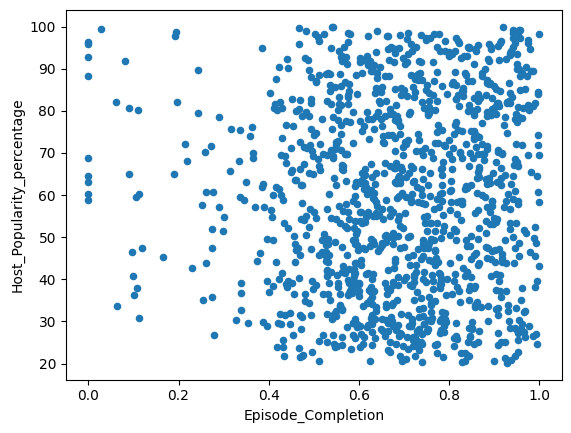

In [19]:
df_.sample(1200).plot.scatter(x='Episode_Completion', y='Host_Popularity_percentage')
plt.show() # Shows the plot

Taking a subsample of 1,000 data points across all episodes and all podcasts, there doesn't seem to be a 
clear correlation between the popularity of the host and the percentage of episode completion. Episode
completion rate matches the distribution above, and seems mostly independent of the a host's
popularity.

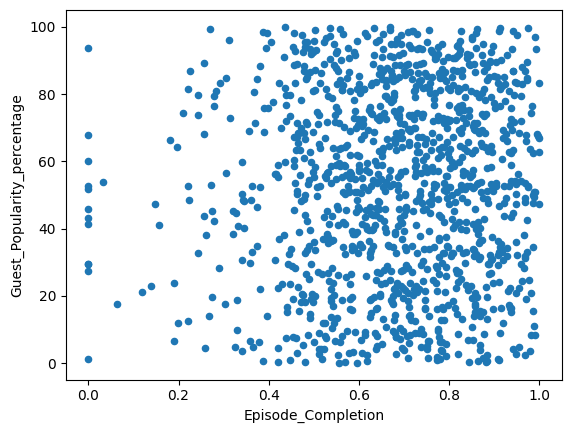

In [20]:
df_.sample(1200).plot.scatter(x='Episode_Completion', y='Guest_Popularity_percentage')
plt.show() # Shows the plot

## Distribution of Popularity Values

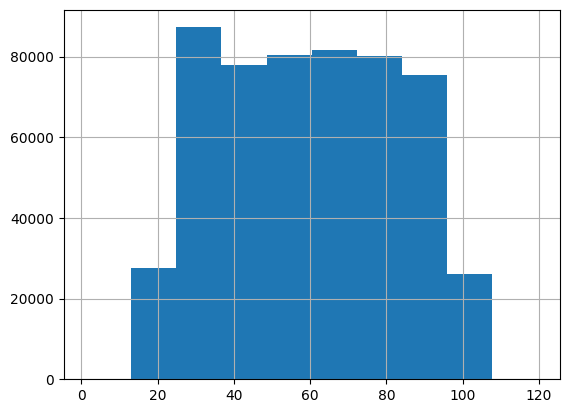

In [21]:
df_["Host_Popularity_percentage"].hist()
plt.show()

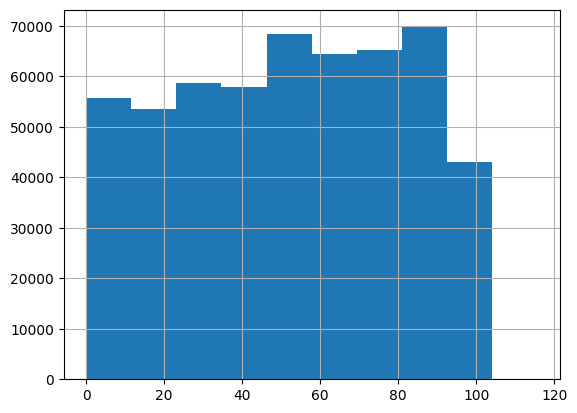

In [22]:
df_["Guest_Popularity_percentage"].hist()
plt.show()

# Ad Rate Per Hour

In [23]:
df_["AdsPerHour"] = df_["Number_of_Ads"] / ( df_["Episode_Length_minutes"] / 60 )

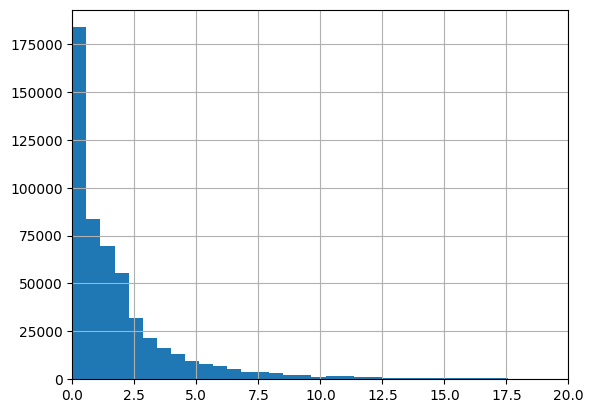

In [24]:
df_["AdsPerHour"].hist(bins=100)
plt.xlim(0,20)
plt.show()

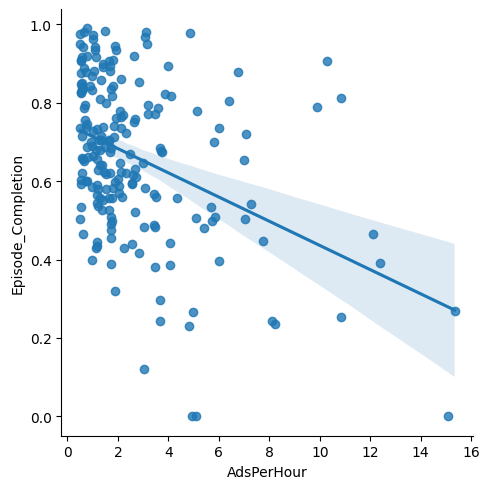

In [27]:
df_only_ads = df_[ df_["AdsPerHour"] > 0 ]
import seaborn as sns
sns.lmplot(x='AdsPerHour',y='Episode_Completion',data=df_only_ads.sample(200),fit_reg=True) 
#plt.xlim(-0.2,10.2)
plt.show()